# 0. IMPORTS

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier as KNN

import warnings
from kaggle.api.kaggle_api_extended import KaggleApi
from IPython.display import display, HTML
from os import remove

## 0.1. Helper Funcions

In [159]:
def precision_top_k(df, k):
    return df['Response'].head(k).sum()/k



def average_precision_at_k(df, k):
    def calc():
        for i in range(1, k + 1):
            yield precision_top_k(df, i)
            
    return np.mean(list(calc()))



def ml_result(val, k, model_name, prediction):
    df = val.copy()
    df['PropensityScore'] = prediction[:, 1]
    df = df.sort_values(by = "PropensityScore", ascending = False)

    p_at_k = precision_top_k(df, k)
    ap_at_k = average_precision_at_k(df, k)

    return pd.DataFrame([[model_name, p_at_k, ap_at_k]], columns = ['Model', "Precision@{}".format(k), "AP@{}".format(k)], index = [0])

## 0.2. Basic Settings

In [2]:
warnings.filterwarnings('ignore')

display(HTML("<style>.container { width:100% !important; }</style>"))

seed = 0

## 0.3. Loading Data

In [3]:
kaggle = KaggleApi()
kaggle.authenticate()

kaggle.dataset_download_files('anmolkumar/health-insurance-cross-sell-prediction', unzip = True);

df_raw = pd.read_csv('train.csv', encoding = 'unicode_escape')
df_final_test = pd.read_csv('test.csv', encoding = 'unicode_escape')

remove('train.csv')
remove('test.csv')
remove('sample_submission.csv')

## 0.4. Train Test Split

In [4]:
df_train_val_raw, df_test_raw = train_test_split(df_raw, train_size = 0.8, shuffle = True, random_state = seed)

# 1. DATA DESCRIPTION

In [5]:
df1 = df_train_val_raw.copy()

## 1.1. Rename Columns

In [6]:
df1.columns = ['ID', 'Gender', 'Age', 'HaveDrivingLicense', 'RegionCode',
               'PreviouslyInsured', 'VehicleAge', 'HaveDamagedVehicle', 'AnnualCost',
               'CommunicationChannel', 'CustomerSinceDays', 'Response']

## 1.2. Data Dimensions

In [7]:
n_rows, n_cols = df1.shape

print('Number of Rows: {}\nNumber of Columns: {}'.format(n_rows, n_cols))

Number of Rows: 304887
Number of Columns: 12


## 1.3. Data Types

In [8]:
df1.dtypes

ID                        int64
Gender                   object
Age                       int64
HaveDrivingLicense        int64
RegionCode              float64
PreviouslyInsured         int64
VehicleAge               object
HaveDamagedVehicle       object
AnnualCost              float64
CommunicationChannel    float64
CustomerSinceDays         int64
Response                  int64
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

ID                      0
Gender                  0
Age                     0
HaveDrivingLicense      0
RegionCode              0
PreviouslyInsured       0
VehicleAge              0
HaveDamagedVehicle      0
AnnualCost              0
CommunicationChannel    0
CustomerSinceDays       0
Response                0
dtype: int64

## 1.5 Fillout NA

## 1.6. Changing Data Types

In [10]:
# RegionCode
df1['RegionCode'] = df1['RegionCode'].astype('object')

# HaveDamagedVehicle
df1['HaveDamagedVehicle'] = df1['HaveDamagedVehicle'].map({'Yes': 1, 'No': 0 })

# CommunicationChannel
df1['CommunicationChannel'] = df1['CommunicationChannel'].astype('object')

## 1.7. Descriptive Analysis

In [11]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64']).drop("ID", axis = 1)
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

### 1.7.1. Numerical Attributes

In [12]:
# Central Tendency
means = pd.DataFrame(num_attributes.apply(np.mean)).T
medians = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion
stds = pd.DataFrame(num_attributes.apply(np.std)).T
skews = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtoses = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
maxima = pd.DataFrame(num_attributes.apply(max)).T
minima = pd.DataFrame(num_attributes.apply(min)).T
value_range = pd.DataFrame(num_attributes.apply(lambda x: max(x) - min(x))).T

In [13]:
stats = pd.concat([minima, maxima, value_range, means, medians, stds, skews, kurtoses]).T
stats.columns = ["Min", "Max", "Range", "Mean", "Median", "Std", "Skew", "Kurtosis"]
stats

,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
Age,20.0,85.0,65.0,38.821127,36.0,15.504253,0.672074,-0.566798
HaveDrivingLicense,0.0,1.0,1.0,0.997871,1.0,0.046088,-21.605240,464.789436
PreviouslyInsured,0.0,1.0,1.0,0.458285,0.0,0.498257,0.167446,-1.971975
HaveDamagedVehicle,0.0,1.0,1.0,0.504715,1.0,0.499978,-0.018860,-1.999657
AnnualCost,2630.0,540165.0,537535.0,30578.576873,31684.0,17196.830459,1.695928,31.490580
CustomerSinceDays,10.0,299.0,289.0,154.190539,154.0,83.716529,0.005773,-1.202021
Response,0.0,1.0,1.0,0.122452,0.0,0.327807,2.303489,3.306083


### 1.7.2. Categorical Attributes

In [14]:
cat_attributes.describe().T

,count,unique,top,freq
Gender,304887,2,Male,164789
RegionCode,304887.0,53.0,28.0,85135.0
VehicleAge,304887,3,1-2 Year,160155
CommunicationChannel,304887.0,154.0,152.0,107895.0


# 2. FEATURE ENGINEERING

In [15]:
df2 = df1.copy()

## 2.1. Hypotheses

## 2.2. Feature Creation

# 3. VARIABLE FILTERING

In [16]:
df3 = df2.copy()

## 3.1. Row Filtering

## 3.2. Columns Filtering

# 4. EXPLORATORY DATA ANALYSIS

In [17]:
df4 = df3.copy()

## 4.1. Univariate Analysis

## 4.2. Bivariate Analysis

## 4.3. Multivariate Analysis

# 5. DATA PREPARATION

In [18]:
df5 = df4.copy()

## 5.1. Encoding

In [19]:
# Gender
df5['Gender'] = df5['Gender'].map({'Female': -1, "Male": 1})

# VehicleAge
le_va = LabelEncoder()
df5['VehicleAge'] = le_va.fit_transform(df5['VehicleAge'])

# 6. FEATURE SELECTION

In [119]:
df6 = df5.copy()

## 6.1. Data Splitting

In [120]:
train, val = train_test_split(df6, test_size = 0.25, shuffle = True, random_state = seed)

x_train = train.drop('Response', axis = 1)
y_train = train['Response']

x_val = val.drop('Response', axis = 1)
y_val = val['Response']

## 6.2. Manual Selection

In [121]:
selected_columns_manual = ['Gender', 'Age', 'HaveDrivingLicense', 'RegionCode',
       'PreviouslyInsured', 'VehicleAge', 'HaveDamagedVehicle', 'AnnualCost',
       'CommunicationChannel', 'CustomerSinceDays', 'Response']

## 6.3. Selection

In [122]:
df6 = df6.loc[:, selected_columns_manual]

# 7. MACHINE LEARNING MODELLING

In [163]:
k = 2000

## 7.1. K-Nearest Neighbors

### 7.1.1. Single Model

In [164]:
knn = KNN()
knn.fit(x_train, y_train)

predict_knn = knn.predict_proba(x_val)

result_knn = ml_result(val, k, 'KNN', predict_knn)

result_knn

,Model,Precision@2000,AP@2000
0,KNN,0.1355,0.151868


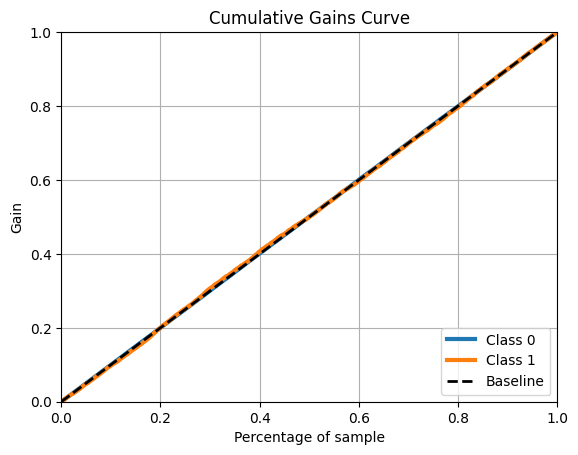

In [166]:
skplt.metrics.plot_cumulative_gain(df['Response'], predict_knn);

# 8. HYPERPARAMETERS FINE TUNING

In [95]:
df8 = df7.copy()

# 9. RESULT INTERPRETATION

In [96]:
df9 = df8.copy()

# 10. DEPLOYMENT